In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import xarray as xr

In [30]:
runoff_path = r"data/catchments/GRDC-Daily.nc"
bentfeld_path = r"data/bentfeld"

runoff = xr.open_mfdataset(runoff_path).load()
runoff = runoff.sel(time=slice('2001-01-01', '2021-12-31'))

bentfeld_id = runoff["station_name"].values == "BENTFELD"
bentfeld_index = np.where(bentfeld_id)[0][0]

# Select only that timeseries
runoffBentfeld = runoff["runoff_mean"].isel(id=bentfeld_index)


treia_path = r"data/catchment_timeseries/treia"
klempenow_path = r"data/catchment_timeseries/klempenow"

temperature = xr.open_mfdataset(bentfeld_path + '/temperature.nc', combine='by_coords').load()
precipitation = xr.open_mfdataset(bentfeld_path + '/precipitation.nc', combine='by_coords').load()
radiation = xr.open_mfdataset(bentfeld_path + '/radiation.nc', combine='by_coords').load()
ndvi = xr.open_mfdataset(bentfeld_path + '/ndvi.nc', combine='by_coords').load()

data = xr.Dataset()
data['temperature'] = temperature['t2m']
data['precipitation'] = precipitation['precipitation']
data['radiation'] = radiation['nr']
data['ndvi'] = ndvi['ndvi']
data['observedRunoff'] = runoffBentfeld.broadcast_like(radiation['nr'])

#get rid of anythin before 2000 and after 2022
data = data.sel(time=slice('2000-03-01', '2022-12-19'))

In [45]:
temperature['t2m'].mean(dim=("x", "y"))

<xarray.DataArray 't2m' (time: 8329)> Size: 33kB
array([276.96765, 275.4285 , 277.40012, ..., 267.13934, 269.45438,
       276.83643], shape=(8329,), dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 67kB 2000-03-01 2000-03-02 ... 2022-12-19
    spatial_ref  int64 8B 0

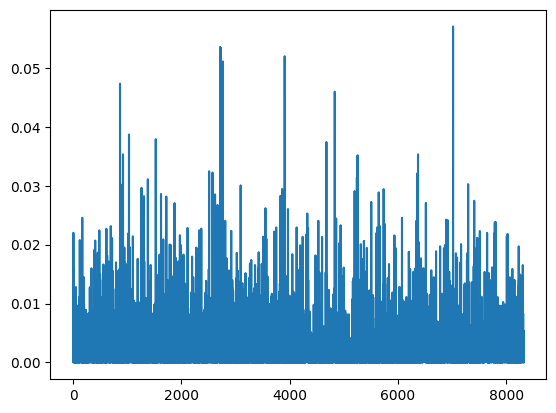

In [ ]:
ts = temperature['t2m'].mean(dim=("x", "y"))
mask = ~np.isnan(ts)
ts = ts[mask]
ts = ts + 0.1
ts_boxcox, lmbda = boxcox(ts)
ts_inv = inv_boxcox(ts_boxcox, lmbda) - 0.1
plt.plot(ts_inv)

In [93]:
ts = temperature['t2m'].mean(dim=("x", "y")).values
#ts = precipitation['precipitation'].mean(dim=("x", "y"))
mask = ~np.isnan(ts)
ts = ts[mask]
ts_positive = ts + 0.1
ts_boxcox, lmbda = boxcox(ts_positive)
ts_boxcox = pd.Series(ts_boxcox)

In [94]:
stl = STL(ts_boxcox, period=365, robust=True)
result = stl.fit()

trend = result.trend
seasonal = result.seasonal
remainder = result.resid

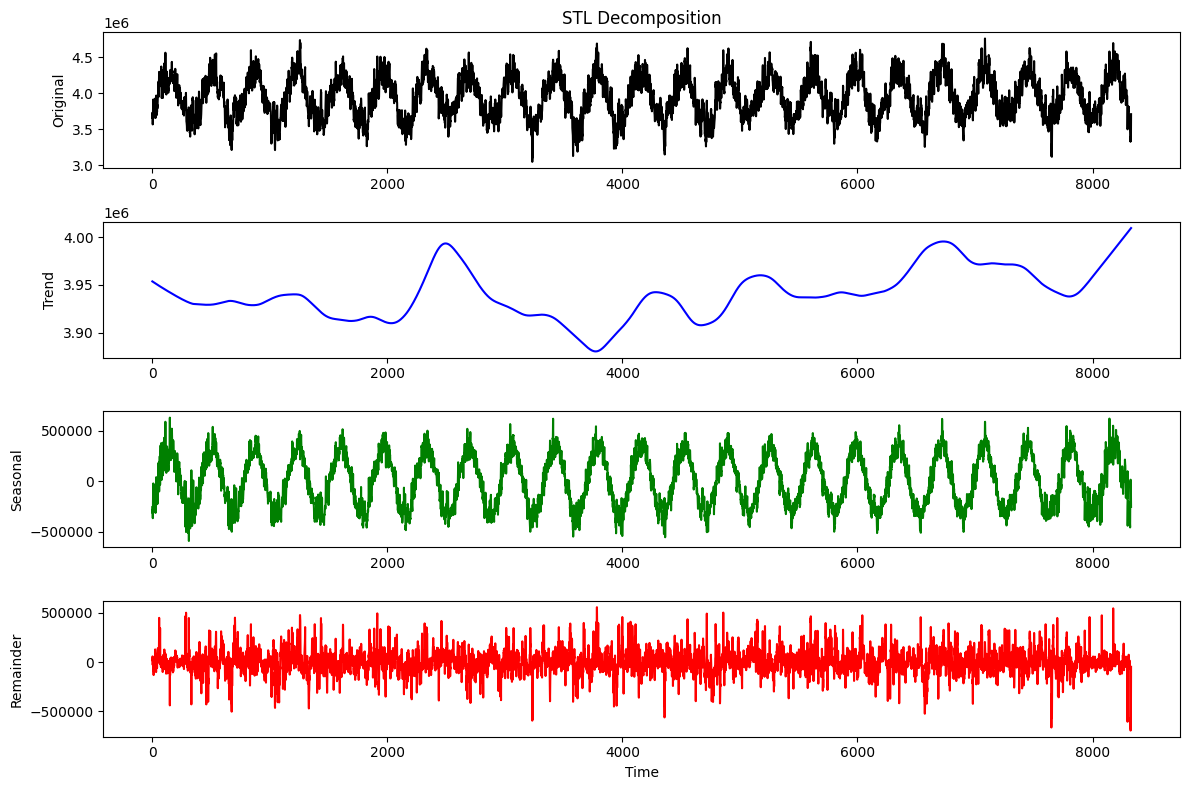

In [95]:
def plot_stl_decomposition(original, trend, seasonal, remainder, title="STL Decomposition"):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(4, 1, 1)
    plt.plot(original, label="Original", color='black')
    plt.title(title)
    plt.ylabel("Original")

    plt.subplot(4, 1, 2)
    plt.plot(trend, label="Trend", color='blue')
    plt.ylabel("Trend")

    plt.subplot(4, 1, 3)
    plt.plot(seasonal, label="Seasonal", color='green')
    plt.ylabel("Seasonal")

    plt.subplot(4, 1, 4)
    plt.plot(remainder, label="Remainder", color='red')
    plt.ylabel("Remainder")
    plt.xlabel("Time")

    plt.tight_layout()
    plt.show()
plot_stl_decomposition(ts_boxcox, trend, seasonal, remainder)

In [89]:
def blocked_bootstrap(series, block_size):
    n = len(series)
    blocks = [series[i:i+block_size] for i in range(0, n - block_size + 1)]
    n_blocks = int(np.ceil(n / block_size))
    boot_series = []
    for _ in range(n_blocks):
        block = blocks[np.random.randint(len(blocks))]
        boot_series.extend(block)
    return np.array(boot_series[:n])

# Bootstrap the remainder
remainder_boot = blocked_bootstrap(remainder.values, block_size=30)
remainder_boot = pd.Series(remainder_boot)

In [90]:
ts_boot_boxcox = trend + seasonal + remainder_boot

# Reverse Box-Cox transformation
ts_boot = inv_boxcox(ts_boot_boxcox, lmbda)
ts_boot = pd.Series(ts_boot)

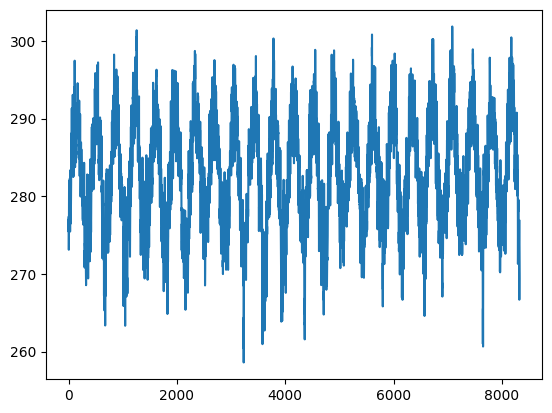

In [69]:
plt.plot(inv_boxcox(ts_boxcox, lmbda))

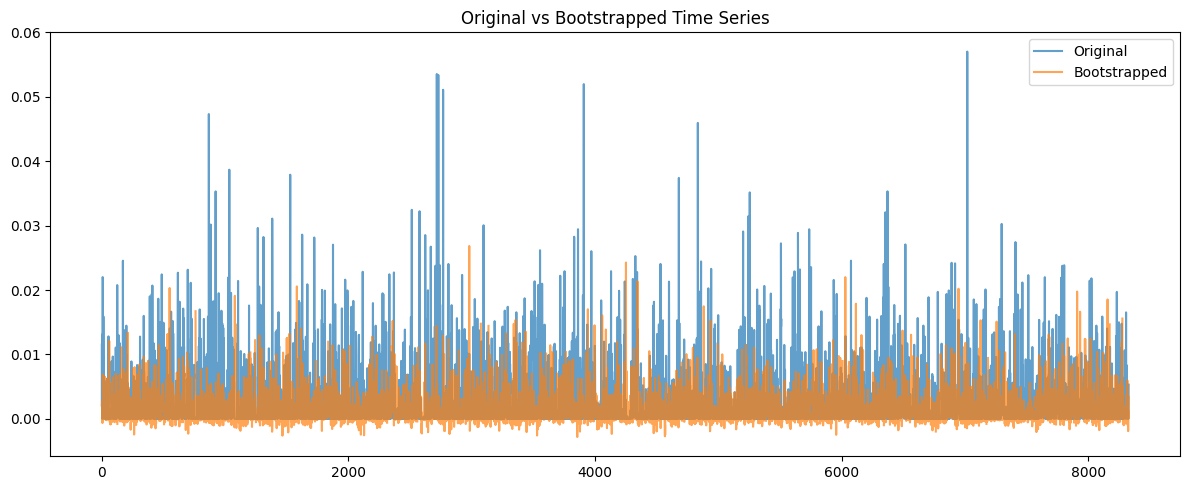

In [92]:
plt.figure(figsize=(12, 5))
plt.plot(ts, label='Original', alpha=0.7)
plt.plot(ts_boot.clip(upper=80)-0.1, label='Bootstrapped', alpha=0.7)
plt.legend()
plt.title('Original vs Bootstrapped Time Series')
plt.tight_layout()
plt.show()

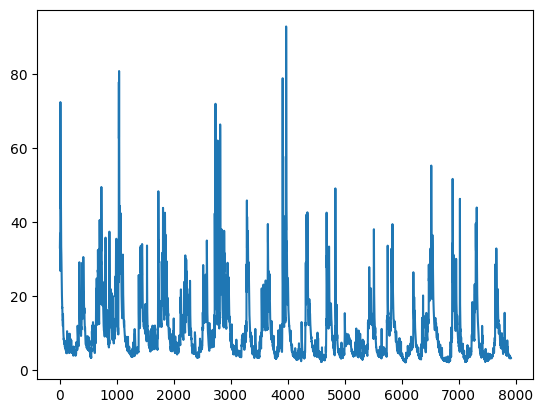

In [12]:
plt.plot(ts)